# Stand-alone code for matched-filter (MF), Power (Bruce's) and Ambiguity chi-square


In [1]:
import numpy as np
import scipy as sp

import pylab as plt
import copy

# %matplotlib inline

MTSUN_SI = 4.925492321898864e-06
c_SI = 299792458
pc_SI = 3.0856775807e+16
PI = 3.141592653589793
Mpc_SI = 1.0e6*pc_SI

In [2]:
def fft(ts, dt):
    return np.fft.rfft(ts) * dt

def ifft(fs, df):
    return np.fft.irfft(fs) * df * (2*len(fs) - 2)

def get_indices(qmin, qmax, delta):
    kmin, kmax = int(1.0*qmin/delta), int(1.0*qmax/delta)
    return kmin, kmax

class TimeSeries(object):
    def __init__(self, data, delta_t, time_stamp=None):
        self.data = data
        self.delta_t = delta_t
        self.time_stamp = time_stamp
        
    def fft(self):
        return FreqSeries(np.fft.rfft(self.data) * self.delta_t, 
                          delta_f=1./(len(self.data)*self.delta_t), time_stamp=self.time_stamp)
    
class FreqSeries(object):
    def __init__(self, data, delta_f, time_stamp=None):
        self.data = data
        self.delta_f = delta_f
        self.time_stamp = time_stamp
        self.freq = np.linspace(0., len(self.data)*self.delta_f, len(self.data))
         
    def ifft(self):
        fmax = 1.0*(len(self.data) - 1)*self.delta_f
        return TimeSeries(np.fft.irfft(self.data) * self.delta_f * (2*len(self.data) - 2), 
                          delta_t=0.5/fmax, time_stamp=self.time_stamp)
    
    def sigma(self, psd=None, flow=30.0, fmax=2048.0):
        kmin, kmax = get_indices(flow, fmax, self.delta_f)
        if psd is not None:
            return np.sqrt(4.0*self.delta_f*(np.abs(self.data[kmin:kmax])**2./psd.data[kmin:kmax]).sum())
        else:
            return np.sqrt(4.0*self.delta_f*(np.abs(self.data[kmin:kmax])**2.).sum())
    

def fd_waveform(mass1=10.0, mass2=1.4, r=100.0, phic=0.0, 
                f_lower=30.0, f_final=2048.0, df=1.0/128.0, return_freq=False):
    """
    mass1, mass2: masses in M_SUN (10., 1.4)
    r: distance in Mpc (100.)
    phic: coalences phase (0.)
    # frequencies in Hz
    f_lower=20.
    f_final=2048.
    delta_f=1./256.
    
    return f, h
    """
    lower_index = int(f_lower / df) 
    m = mass1 + mass2
    eta = mass1 * mass2 / m ** 2.0
    m_sec = m * MTSUN_SI
    pim = PI * m_sec
    amp0 = m_sec ** (5.0 / 6.0) * np.sqrt(5.0 * eta / 24.0) / (PI ** (2.0 / 3.0) * r * Mpc_SI / c_SI)
    psi0 = 3.0 / (128.0 * eta)
    psi2 = 3715.0 / 756.0 + 55.0 * eta / 9.0
    psi3 = 16.0 * PI
    f = np.linspace(0, f_final, int(f_final / df) + 1)
    v = np.zeros_like(f)
    v[lower_index:] = (pim * f[lower_index:]) ** (1.0 / 3.0)
    psi = np.zeros_like(f)
    psi[lower_index:] = psi0 / v[lower_index:] ** 5.0 * (1.0 + psi2 * v[lower_index:] ** 2.0 + psi3 * v[lower_index:] ** 3.0)
    amp = np.zeros_like(f)
    amp[lower_index:] = amp0 * f[lower_index:] ** (-7.0 / 6.0)
    h = amp * np.exp(1j * (psi - 2.0 * phic - PI / 4.0))
    
    return FreqSeries(h, df, None)

def get_fseries(series):
    if isinstance(series, TimeSeries):
        return series.fft()
    elif isinstance(series, FreqSeries):
        return series

def frequency_noise_from_psd(psd):
    """
    psd: same length and df as required noise, if None == White noise  with unit variance
    df: same as psd sampled delta_f
    """
    sigma = 0.5 * (psd.data / psd.delta_f) ** 0.5
    not_zero = sigma != 0
    sigma_red = sigma[not_zero]
    noise_re = np.random.normal(0, sigma_red)
    noise_im = np.random.normal(0, sigma_red)
    noise_red = noise_re + 1.0j * noise_im
    noise = np.zeros(sigma.size, dtype=noise_red.dtype)
    noise[not_zero] = noise_red
    return FreqSeries(noise, psd.delta_f)

def create_empty_time_series_like(ts):
    newts = TimeSeries(np.zeros_like(ts.data), delta=ts.delta_t, time_stamp=ts.time_stamp)
    return newts

def create_empty_freq_series_like(fs):
    newfs = FreqSeries(np.zeros_like(fs.data), delta_f=fs.delta_f, time_stamp=fs.time_stamp)
    return newfs

In [3]:
def matched_filter(template, data, psd=None, f_lower=30., f_final=2048., norm=None):
    '''
    returns mf_timeseries (Tseries), norm, corrf ()
    Actual SNR can be calculated by mf_timeseries / norm
    '''
    ftemplate = get_fseries(template)
    fdata = get_fseries(data)
    
    
    kmin, kmax = get_indices(f_lower, f_final, fdata.delta_f)
    
    if norm is None:
        norm = ftemplate.sigma(psd, f_lower, f_final)
            
    corrf = FreqSeries(np.zeros(fdata.data.shape[0], dtype=ftemplate.data.dtype), 
                       ftemplate.delta_f, fdata.time_stamp)
    
    corrf.data[kmin:kmax] = (fdata.data[kmin:kmax].conj() * ftemplate.data[kmin:kmax])
    
    if psd is not None:
        corrf.data[kmin:kmax] /= psd.data[kmin:kmax]
        
    mat0 = corrf.ifft()
    mat0.data *= (2.0/norm)
    
    corrf = FreqSeries(np.zeros(fdata.data.shape[0], dtype=ftemplate.data.dtype), 
                       ftemplate.delta_f, fdata.time_stamp)
    
    corrf.data[kmin:kmax] = (fdata.data[kmin:kmax].conj() * (1.0j*ftemplate.data[kmin:kmax]))
    
    if psd is not None:
        corrf.data[kmin:kmax] /= psd.data[kmin:kmax]
        
    mat_piby2 = corrf.ifft()
    mat_piby2.data *= (2.0/norm)
    return mat0, mat_piby2      

def phase_maxed_snr(snr0, snrp):
    return (snr0.data**2. + snrp.data**2.)**0.5


def chi_sq_bins_from_template(template, nbins=8, psd=None, f_lower=30., f_final=2048.0):
    kmin, kmax = get_indices(f_lower, f_final, template.delta_f)
    
    cumsnr = np.zeros_like(template.data)
    cumsnr[kmin:kmax] = 4.0*template.delta_f*template.data[kmin:kmax]*template.data[kmin:kmax].conj()
    
    if psd is not None:
        cumsnr[kmin:kmax] /= psd.data[kmin:kmax]
    
    csnr = cumsnr.cumsum()
    
    bins = np.searchsorted(csnr, 1.0*(np.arange(nbins))*csnr.max()/nbins, 'right')
    bins = np.append(bins, len(cumsnr)-1)
    
    return bins

def power_chisq(snr0, snrp, template, data, nbins=8, psd=None, f_lower=30., f_final=2048.0):
    bins = chi_sq_bins_from_template(template, nbins, psd, f_lower, f_final)*template.delta_f
    
    norm = template.sigma(psd, f_lower, f_final)
    chisq = np.zeros_like(snr0)
    for i in range(nbins):
        mat0, matp = matched_filter(template, data, psd, bins[i], bins[i+1], norm)
        chisq = chisq + (mat0.data - snr0.data/nbins)**2. + (matp.data - snrp.data/nbins)**2.
        
    return nbins*chisq

In [3]:
h = fd_waveform()

## We are using PyCBC just to read a PSD
## PSD can be read from file and can be interpolated (in log scale, for better interpolation) for the required delta_f, f_lower, f_final
import pycbc.psd as pp
psd1 = pp.aLIGOZeroDetHighPowerGWINC(len(h.data), h.delta_f, 30.)

psd = FreqSeries(psd1.data, psd1.delta_f)
h.data /= h.sigma(psd)

ImportError: No module named pycbc.psd

In [5]:
g = fd_waveform(phic=np.pi/8.)
g.data /= (g.sigma(psd)/10)
snr0, snrp = matched_filter(h, g, psd)
snr = phase_maxed_snr(snr0, snrp)

In [6]:
print snr0.data[0], snrp.data[0], snr[0]

7.07106781187 -7.07106781187 10.0


In [7]:
nbins = 8
dof = 2*nbins - 2
c = power_chisq(snr0, snrp, h, g, nbins, psd)

In [8]:
# For nbins, dof = 2*nbins-2, c.mean = dof, c.var = 2*dof
for i in range(5):
    n = frequency_noise_from_psd(psd)
    snr0, snrp = matched_filter(h, n, psd)
    c = power_chisq(snr0, snrp, h, n, nbins, psd)
    print c.mean(), c.var()

14.1032781882 29.1463435676
13.9359457373 28.3483370707
13.9854666684 27.8174020712
14.1281489076 27.6551979541
14.1426810691 29.5294314164


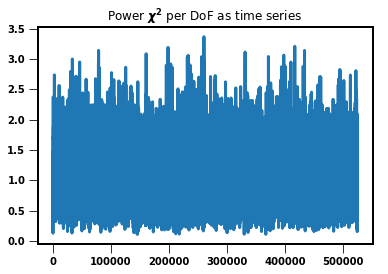

In [9]:
plt.plot(c/dof); 
plt.title(r'Power $\chi^2$ per DoF as time series');
plt.show()

In [10]:
hist, bins = np.histogram(c, bins=100)
thist, _ = np.histogram(np.random.chisquare(dof, len(c)), bins)

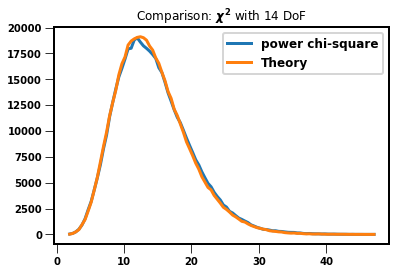

In [11]:
plt.plot(bins[1:], hist, label='power chi-square');
plt.plot(bins[1:], thist, label='Theory');
plt.title(r'Comparison: $\chi^2$ with {0} DoF'.format(dof))
plt.legend()
plt.plt.show()

# Ambiguity Chi-square

In [12]:
# Helper functions
def H_ij(trig_template, template_list, psd=None, f_lower=30., f_final=2048.):
    m = len(template_list)
    hij = np.ones((m, m))
    for i in range(m):
        for j in range(m):
            if i >= j:
                m0, mp = matched_filter(template_list[i], template_list[j], psd, f_lower, f_final)
                normj = template_list[j].sigma(psd, f_lower, f_final)
                hij[i, j] = m0.data[0]/normj
                hij[j, i] = hij[i, j]
    
    return hij

def H_i(trig_template, template_list, psd=None, f_lower=30., f_final=2048.):
    h_0i = []
    h_pi = []
    for t in template_list:
        h0, hp = matched_filter(trig_template, t, psd, f_lower, f_final)
        norm = t.sigma(psd, f_lower, f_final)
        h_0i.append(h0.data[0]/norm)
        h_pi.append(hp.data[0]/norm)
        
    return np.array(h_0i), np.array(h_pi)

def H_iH_j(trig_template, template_list, psd=None, f_lower=30., f_final=2048.):
    h_0i, h_pi = H_i(trig_template, template_list, psd, f_lower, f_final)
    
    return h_0i[:, None]*h_0i[None, :], h_pi[:, None]*h_pi[None, :]

# Covariance matrix
def cov_matrix(trig_template, template_list, psd=None, f_lower=30., f_final=2048.):
    
    from numpy import linalg as la
    
    h_ij = H_ij(trig_template, template_list, psd, f_lower, f_final)
    H_0iH_0j, H_piH_pj = H_iH_j(trig_template, template_list, psd, f_lower, f_final)
    
    cov = h_ij - H_0iH_0j - H_piH_pj
    evals, rot_mat = la.eig(cov)
    idx = evals.argsort()[::-1]
    
    return cov, evals[idx], rot_mat[:, idx]

# Calculate actual chi-square
def ambiguity_chisq(template_list, evals, rot, data, snr0, snrp, trig_template, 
                   psd=None, f_lower=30., f_final=2048., trig_id=[0]):
    
    ## Fixed given trigger template
#     cov, evals, rot = cov_matrix(template_list, psd, f_lower, f_final)
    eidx = evals > 0.
    dof = eidx.sum()

    trig_norm = trig_template.sigma(psd, f_lower, f_final)
    trig_template.data /= trig_norm
    
    rho_i = []
    h0_i = []
    hp_i = []
#     for i in range(len(template_list)):
    for t in template_list:
    
        rho0, _ = matched_filter(t, data, psd, f_lower, f_final)
        rho_i.append(rho0.data) 
        
        h0, _ = matched_filter(t, trig_template, psd) #, f_lower, f_final)
        h0_i.append(h0.data)  
        
        trig_template_p = copy.deepcopy(trig_template)
        trig_template_p.data *= 1.0j
        hp, _ = matched_filter(t, trig_template_p, psd, f_lower, f_final)
        hp_i.append(hp.data)
        
    c_l = []
    for idx in trig_id:
        temp = []
        for k in range(len(template_list)):
            temp.append(rho_i[k][idx] - snr0.data[idx]*h0_i[k][0] - snrp.data[idx]*hp_i[k][0])
#             print h0_i[k][0]
        
        temp = np.array(temp)
        temp = np.dot(rot.T, temp)
        chi = (temp[eidx]*temp[eidx]/evals[eidx]).sum() 
        c_l.append(chi)
    return c_l, dof

In [13]:
# Mass parameter space about the template h
m1s = np.linspace(9.95, 10.05, 5); m2s = np.linspace(1.395, 1.405, 5)

In [14]:
# Nhbd templates for calculation of ambiguity chi sq 
template_list = []

print 'match, match_location'
for m1 in m1s:
    for m2 in m2s:
        g = fd_waveform(m1, m2)
        
        snr0, snrp = matched_filter(g, h, psd)
        m = phase_maxed_snr(snr0, snrp)
        idx = m.argmax()
        if m[idx] < 0.99:
            template_list.append(g)
            print m[idx], idx
            
print 'number of templates in the nhbd list:', len(template_list)

match, match_location
0.419882588308 16
0.506330014725 38
0.674189469815 11
0.927158804536 1
0.966635525022 524286
0.489808616386 45
0.641920134531 16
0.882186243772 2
0.989804345499 524287
0.793765797097 524281
0.613279596166 21
0.835772738348 4
0.836716245713 524284
0.615821816826 524267
0.790629653221 7
0.989549865915 1
0.883181900958 524286
0.643883686443 524272
0.49254537082 524245
0.964455044571 2
0.930205046365 524287
0.677609708934 524277
0.509401856117 524250
0.420416731309 524272
number of templates in the nhbd list: 24


In [15]:
# Get cov matrix (sigma), eigenvalues and eigenvectors as rotation matrix
cov, e, rot = cov_matrix(h, template_list, psd)
print e

[  4.70469071e+00   3.05160911e+00   2.26683761e+00   1.86501299e+00
   1.01893032e+00   6.24723974e-01   2.89297473e-01   1.72786757e-01
   9.26574053e-03   2.78473817e-03   2.06142085e-03   3.15504212e-04
   1.43267564e-05   1.15946551e-05   6.28404352e-06   1.05263429e-07
   1.73106308e-08   1.18428616e-08   9.22843211e-11   2.55148525e-11
   1.31617849e-11   8.39495712e-14   1.78039919e-14   1.12519321e-16]


In [16]:
# Inject CBC (BBH)
g = fd_waveform(10, phic=np.pi/3)
g.data /= (g.sigma(psd)/8)
snr0, snrp = matched_filter(h, g, psd)

h = fd_waveform()
s = phase_maxed_snr(snr0, snrp)
idx = s.argmax()
print idx, s[idx]

0 8.0


In [17]:
# Calculate ambi chi-sq for trigger and some other random point, 10, to check multi-trigger working
chi, dof = ambiguity_chisq(template_list, e, rot, g, snr0, snrp, h, psd, trig_id=[idx, 10])
print chi/dof#, snr0.data[idx], snrp.data[idx], idx

[  2.82497502e-16   1.26087715e+00]


In [18]:
# Ambi chi-sq for gaussian noise only case 
# Triggers all over the noise matched filter as trig_id just to get the stat-distribution
n = frequency_noise_from_psd(psd)
n.data += g.data
snr0, snrp = matched_filter(h, n, psd)
chi, dof = ambiguity_chisq(template_list, e, rot, n, snr0, snrp, h, psd, trig_id=np.arange(0, 500000, 10))

In [19]:
chi = np.array(chi)
print dof
print chi/dof

24
[ 0.54441672  2.33664282  1.88882223 ...,  0.83040134  0.72954321
  0.6661082 ]


In [20]:
hist, bins = np.histogram(chi, bins=30)
thist, _ = np.histogram(np.random.chisquare(dof, len(chi)), bins)

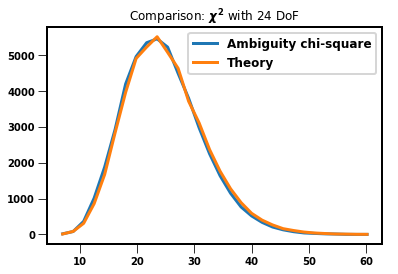

In [21]:
plt.plot(bins[1:], hist, label='Ambiguity chi-square');
plt.plot(bins[1:], thist, label='Theory');
plt.title(r'Comparison: $\chi^2$ with {0} DoF'.format(dof))
plt.legend()
plt.plt.show()

In [12]:
# To fet Sine-Gaussian (SG) injections using PyCBC
# These SG can be code here separately in time or freq domain as can be used as stand alone

import pycbc.waveform as pw
import pycbc.vetoes as pv
import pycbc.types as pt
import pycbc.filter as pf

In [73]:
print 'SG glitch: SNR, time, Ambi chi-sq, power' #, DoF, chi-sq per DoF for the SG giitch'
q_l = [21, 22] # np.linspace(20., 40., 3)
f0_l = [31, 32, 33, 34] # np.linspace(30., 80., 3)
nbins = 8
qs = np.linspace(1, 50, 20)
f0s = np.linspace(40, 120, 20)
chi_l = []

h = fd_waveform()
# 
for q in qs:
    for f0 in f0s:
        g = create_empty_freq_series_like(h)
        sg, _ = pw.get_sgburst_waveform(approximant='TaylorF2', q=q, frequency=f0, 
                                        delta_t=1./4096, hrss=3e-22, amplutude=1)
        n = frequency_noise_from_psd(psd)
        sg.resize(len(h.data)*2-2)
        sg = sg.to_frequencyseries()
        g.data = sg.data #+n.data

        snr0, snrp = matched_filter(h, g, psd)
        snr1 = phase_maxed_snr(snr0, snrp)
        idx = snr1.argmax()

        g.data /= (snr1[idx]/10.0)

        snr0, snrp = matched_filter(h, g, psd)
        snr1 = phase_maxed_snr(snr0, snrp)
        idx = snr1.argmax()

        c = power_chisq(snr0, snrp, h, g, nbins, psd)
        chi_l.append(c[idx])

SG glitch: SNR, time, Ambi chi-sq, power


In [75]:
chi_l = np.array(chi_l).reshape(20, 20)

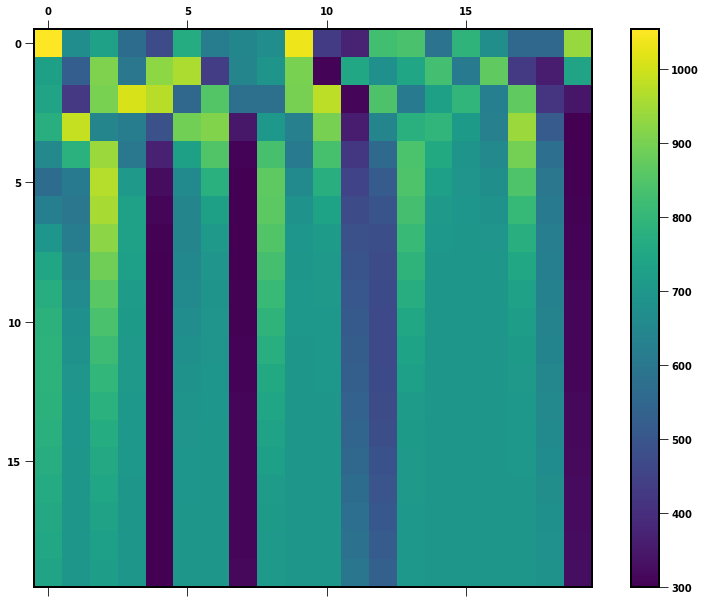

In [101]:
plt.figure(figsize=(14, 10))
# plt.imshow(chi_l, origin='lower', interpolation='bilinear')
# plt.colorbar()

plt.matshow(chi_l,fignum=1)
# plt.imshow(np.arange(100).reshape(10, 10))
plt.colorbar()
plt.show()

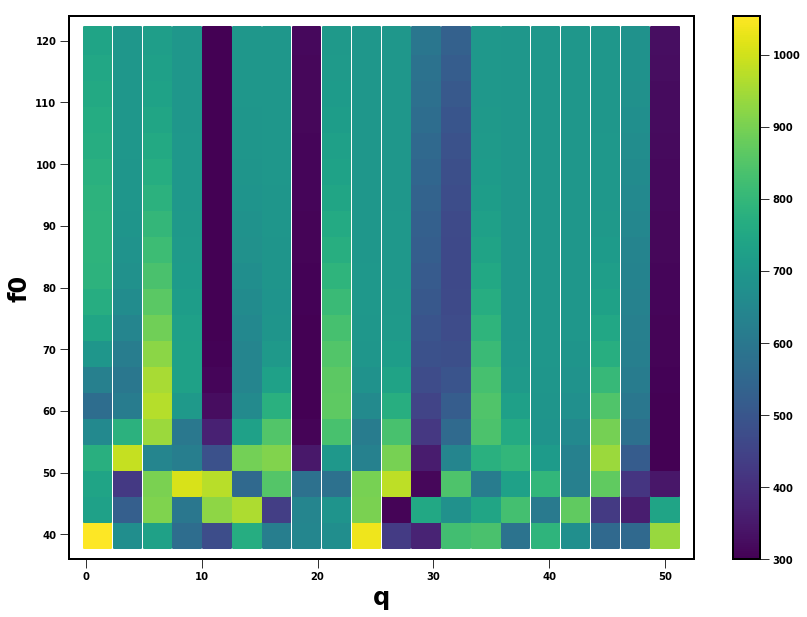

In [86]:
qq, f0f0 = np.meshgrid(qs, f0s)
plt.figure(figsize=(14, 10))
plt.scatter(qq, f0f0, c=chi_l, marker='s', s=750)
plt.xlabel('q')
plt.ylabel('f0')
plt.colorbar()
plt.show()

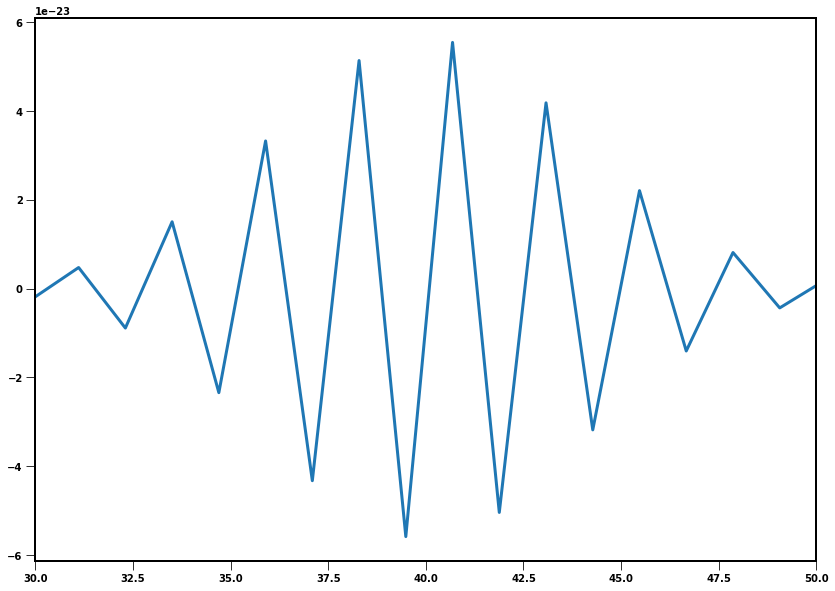

In [59]:
f0 = 40.
q = 10.
sg, _ = pw.get_sgburst_waveform(approximant='TaylorF2', q=q, frequency=f0, 
                                delta_t=1./4096, hrss=3e-22, amplutude=1)
fsg = sg.to_frequencyseries()


plt.figure(figsize=(14, 10))
plt.plot(fsg.sample_frequencies, fsg);
plt.xlim(f0-10, f0+10)
# plt.plot(sg.sample_times, sg);
plt.show()